In [1]:
import os, shutil, copy, ntpath, datetime
import keras
from keras import models, layers, callbacks
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

import matplotlib.pyplot as plt

import boto3
import glob
import ntpath
import re

import numpy as np

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#### Settings
IMAGE_SHAPE=(150, 150, 3)

#LIMIT_BATCHES = 2
LIMIT_BATCHES = None

NUM_EPOCHS = 20
BATCH_SIZE = 20
NUM_CLASSES = 29

# PRETRAIN_MODEL = 'conv_base_local'
# PRETRAIN_MODEL = 'conv_base_vgg16'
PRETRAIN_MODEL = None

In [3]:
#### FilePath Information
DATA_DIR = '../data'
ASL_ALPHABET_DATASET = os.path.join(DATA_DIR, 'original/asl_alphabet')


SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/asl_alphabet')

In [4]:
#data generation setip


In [5]:
# dataset definition with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    )
test_datagen = ImageDataGenerator(rescale=1./255)
# end without augmentation

In [6]:
#create generators
train_generator = train_datagen.flow_from_directory(
           ASL_ALPHABET_DATASET,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='training'
)

#create generators
validation_generator = train_datagen.flow_from_directory(
           ASL_ALPHABET_DATASET,
           target_size = (IMAGE_SHAPE[0], IMAGE_SHAPE[0]),
           batch_size=BATCH_SIZE,
           class_mode = 'categorical',
           subset='validation'
)


Found 78289 images belonging to 29 classes.
Found 8698 images belonging to 29 classes.


In [7]:
callbacks_list = [
         callbacks.EarlyStopping(monitor='acc', patience=2),
         callbacks.ModelCheckpoint(filepath = '../data/models/handsigns/handsigns.h5', monitor = 'val_loss', save_best_only = True),
         callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=10)
]


model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMAGE_SHAPE))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

#Add a classfier on top of the convnet
model.add(layers.Flatten())
model.add(layers.Dropout(.5))
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

#compile the model
optimizer = keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       73856     
__________

In [8]:
history= model.fit_generator (
           train_generator,
           epochs = NUM_EPOCHS,
           steps_per_epoch=LIMIT_BATCHES,
           #callbacks = callbacks_list,
           validation_data=validation_generator,
           verbose=1)

Epoch 1/20
3915/3915 [==============================] - 2024s 517ms/step - loss: 2.8387 - acc: 0.1790 - val_loss: 2.2824 - val_acc: 0.2867
Epoch 2/20
3915/3915 [==============================] - 2025s 517ms/step - loss: 1.7799 - acc: 0.4402 - val_loss: 1.5110 - val_acc: 0.5172
Epoch 3/20
3915/3915 [==============================] - 1961s 501ms/step - loss: 1.2377 - acc: 0.5977 - val_loss: 1.4033 - val_acc: 0.5220
Epoch 4/20
3915/3915 [==============================] - 1953s 499ms/step - loss: 0.9259 - acc: 0.6964 - val_loss: 1.0985 - val_acc: 0.6323
Epoch 5/20
3915/3915 [==============================] - 2019s 516ms/step - loss: 0.7249 - acc: 0.7578 - val_loss: 1.0108 - val_acc: 0.6507
Epoch 6/20
3915/3915 [==============================] - 2063s 527ms/step - loss: 0.5950 - acc: 0.7993 - val_loss: 0.8833 - val_acc: 0.7072
Epoch 7/20
3915/3915 [==============================] - 1957s 500ms/step - loss: 0.5110 - acc: 0.8265 - val_loss: 0.7980 - val_acc: 0.7253
Epoch 8/20
3915/3915 [=====

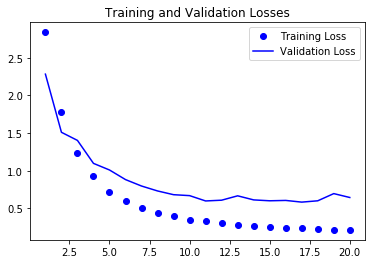

In [9]:
#visualization of model performance
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values =  history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()
plt.show()

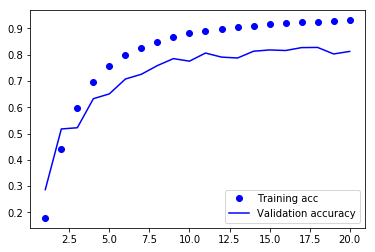

In [10]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs,val_acc_values, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.legend()

plt.show()

## Save things

In [11]:
def get_test_filenames():
    glob_filepath = os.path.join(ASL_ALPHABET_DATASET, '*_test.jpg')
    filepaths_with_test_string = glob.glob(glob_filepath)
    just_filenames = [ntpath.basename(f) for f in filepaths_with_test_string]
    return just_filenames

In [12]:
def get_label_from_filename(filename):
    # example "F_test.jpg" will be just "F"
    return re.split('_', filename)[0]

In [13]:
def load_image_from_filename(filename):
    filepath = os.path.join(ASL_ALPHABET_DATASET, filename)
    img = load_img(filepath, target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    return img_to_array(img)

In [14]:
def get_label_encoded(label):
    encoding = np.zeros(NUM_CLASSES)
    index = train_generator.class_indices[label]
    encoding[index] = 1
    return encoding

In [15]:
def get_test_data():
    test_filenames = get_test_filenames()
    labels = [get_label_from_filename(filename) for filename in test_filenames]
    label_encoded = [get_label_encoded(label) for label in labels]
    images = [load_image_from_filename(filename) for filename in test_filenames]
    return (images, label_encoded)

In [16]:
x_test, y_test = get_test_data()

In [17]:
def ensure_model_directory_exists():
    try:
        os.mkdir(SAVED_MODEL_DIR)
    except:
        print('Tried to create "{}" but it already exists'.format(SAVED_MODEL_DIR))

def save_model():
    ensure_model_directory_exists()
    
    evaluate_model_with_test_data = model.evaluate([x_test], np.array(y_test))

    accuracy_of_model = evaluate_model_with_test_data[-1]
    timestamp_raw = str(datetime.datetime.now())
    timestamp_without_milliseconds = timestamp_raw.split('.')[0]
    
    model_filename = '{}___{}.h5'.format(timestamp_without_milliseconds, accuracy_of_model)
    model_filepath = os.path.join(SAVED_MODEL_DIR, model_filename)
    
    print('saving file {}'.format(model_filepath))

    model.save(model_filepath)
    return accuracy_of_model
mae = save_model()

Tried to create "../data/models/asl_alphabet" but it already exists
28/28 [==============================] - 0s 6ms/step
saving file ../data/models/asl_alphabet/2018-12-07 23:33:04___0.25.h5


In [18]:
# Send text message when complete (if the environment variable "TEXT_PHONENUMBER" is set)
if 'TEXT_PHONENUMBER' in os.environ:
    text_phonenumber = os.environ['TEXT_PHONENUMBER']
    client = boto3.client('sns')
    client.publish(PhoneNumber=text_phonenumber, Message='Model Finished with mae {}'.format(mae))
    print('text sent')

text sent


# Find Largest Errors

In [19]:
from keras.models import load_model

In [20]:
# model = load_model('../data/models/asl_alphabet/2018-12-07 04:36:16___0.9285714030265808.h5')

In [21]:
# a = model.evaluate_generator(validation_generator)

In [22]:
images, class_vectors = next(validation_generator)

c = None
validations = []

# validations.append()
c = class_vectors
#print(class_vectors)
predictions = model.predict(images)
for class_vector, prediction in zip(class_vectors, predictions):
    true_class = class_vector.argmax(axis=-1)
    validations.append({
        'true_class': true_class,
        'prediction': prediction.argmax(axis=-1)
    })
predictions

array([[9.75617953e-03, 3.62603503e-10, 2.70631544e-30, 5.53198869e-28,
        9.90242064e-01, 1.03389550e-24, 6.60965033e-11, 6.41788799e-18,
        8.89756180e-08, 4.81760534e-11, 2.08694889e-17, 2.28957878e-21,
        1.68517317e-06, 3.58702317e-15, 4.33020660e-24, 3.79260688e-26,
        7.84179687e-32, 5.06381484e-18, 5.50380921e-11, 6.57438730e-13,
        1.27383694e-21, 1.62449609e-21, 5.69893949e-26, 9.82230139e-13,
        1.02856339e-20, 1.61706598e-19, 5.68762698e-25, 7.12961521e-24,
        7.07664752e-30],
       [3.05974039e-34, 6.54805396e-26, 0.00000000e+00, 4.92475792e-18,
        3.64521292e-31, 6.55348658e-23, 2.75556504e-15, 1.90556079e-21,
        1.08904557e-13, 9.36951680e-22, 9.99992609e-01, 2.71673229e-19,
        5.02827370e-33, 0.00000000e+00, 5.53437635e-24, 1.78830551e-30,
        2.81751235e-38, 2.72356844e-13, 0.00000000e+00, 4.97817995e-23,
        6.90621037e-26, 7.35203457e-06, 8.43338782e-15, 4.44596980e-28,
        1.54376612e-27, 4.25788226e-24,

In [23]:
#plt.imshow(array_to_img(images[3]))

In [24]:
#validation_generator.class_indices

In [25]:
#validations

In [26]:
# go through each predicted item
# get its true class
# Find the ones that are wrong
# Order by which are MOST wrong
